### Callin Switzer

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import os
import csv
import time
from scipy import signal
import itertools as it
import sys
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import scipy.io
import glob
import itertools

In [2]:
# data directory
dataDir = r"D:\Dropbox\dataAnalysisForOthers\MothMuscleLength\Data"

# figure directory
figDir = r"D:\Dropbox\dataAnalysisForOthers\MothMuscleLength\Figures" 
if not os.path.exists(figDir):
    os.makedirs(figDir)

In [3]:
# read in data

def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

DLTFolders = listdir_fullpath(os.path.join(dataDir, "DLT viewer output"))
DLTFiles = [[ii for ii in glob.glob(os.path.join(DLTFolders[ii], "**_xypts**")) 
 if not os.path.basename(os.path.normpath(ii)).startswith("_")] for ii in range(len(DLTFolders))]
DLTFiles = list(itertools.chain(*DLTFiles))

MuscleFiles = [i for i in listdir_fullpath(os.path.join(dataDir, "muscle_matlab_abby"))  
               if  i.endswith(".csv") & (not os.path.basename(os.path.normpath(i)).startswith("_"))]


In [19]:
# read in DLT files
framerate = 1000.0
frame = pd.DataFrame()
list_ = []
for file_ in DLTFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    df["ID"] = os.path.basename(os.path.normpath(os.path.dirname(file_)))
    df["timestamp"] = np.arange(0, len(df)/framerate, step = 1/framerate )
    df["filename"] = os.path.basename(file_)
    list_.append(df)
frame = pd.concat(list_, sort = False)
frame = frame.dropna(axis=1, how='all')
print(frame.shape)
frame.set_index('filename', inplace=True)


(36040, 27)


            filename             
pt1_cam1_X  DLTdv6_data_xypts.csv    NaN
            DLTdv6_data_xypts.csv    NaN
            DLTdv6_data_xypts.csv    NaN
            DLTdv6_data_xypts.csv    NaN
            DLTdv6_data_xypts.csv    NaN
dtype: object

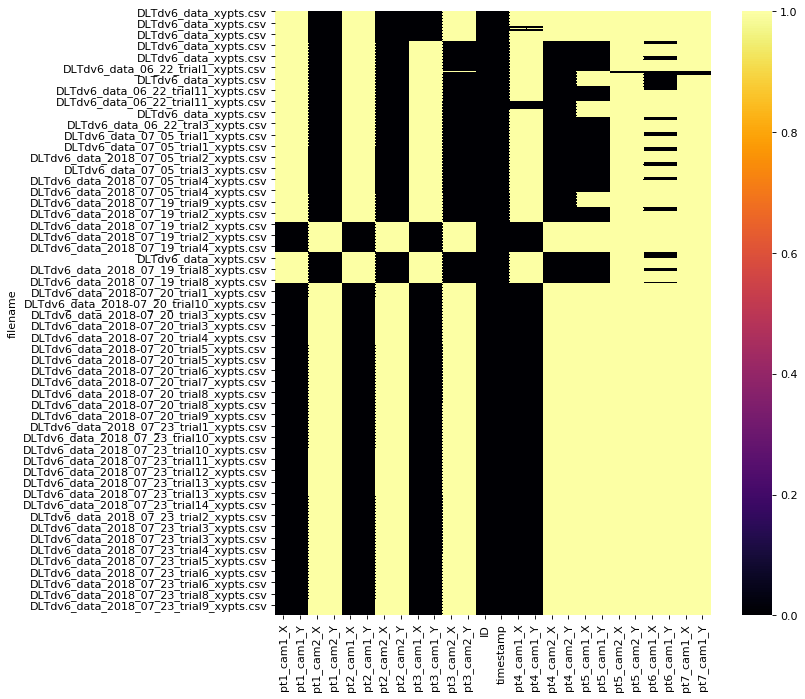

In [15]:
# visualize missing
fig = plt.figure(figsize=(10, 10), dpi=80)
ax = fig.add_subplot(111)
ax.set_aspect(aspect=0.001)
sns.heatmap(frame.iloc[:,:].isna(), cbar=True, ax=ax, cmap = "inferno")

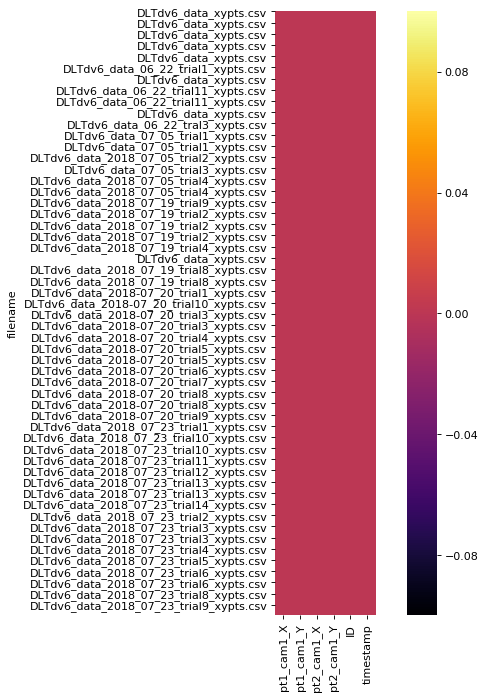

In [20]:
# combine columns
frame['pt1_cam1_X'] = frame['pt1_cam1_X'].combine_first(frame['pt1_cam2_X'])
frame['pt2_cam1_X'] = frame['pt2_cam1_X'].combine_first(frame['pt2_cam2_X'])
frame['pt1_cam1_Y'] = frame['pt1_cam1_Y'].combine_first(frame['pt1_cam2_Y'])
frame['pt2_cam1_Y'] = frame['pt2_cam1_Y'].combine_first(frame['pt2_cam2_Y'])
fig = plt.figure(figsize=(10, 10), dpi=80)
ax = fig.add_subplot(111)
ax.set_aspect(aspect=0.001)
sns.heatmap(frame.dropna(axis=1, how="any").isna(), cbar=True, ax=ax, cmap = "inferno")

In [21]:
frame = frame.dropna(axis=1, how="any")

frame = frame.reset_index(drop=True)

muscleBases = [os.path.basename(os.path.splitext(file_)[0]) for file_ in MuscleFiles]
muscleDate = [ss[:10] for ss in muscleBases]

def convInt(string):
    try:
        return(int(string))
    except:
        return(-9999)
    
muscleTrialNum = [convInt(''.join(c for c in ss.split("_")[3] if c.isdigit())) for ss in muscleBases]

muscleDateTrial = pd.concat([pd.Series(muscleDate), pd.Series(muscleTrialNum), pd.Series(muscleBases), pd.Series(MuscleFiles)], axis=1)
muscleDateTrial.rename(columns={0: "date", 1: "trial", 2:"muscleBase", 3:"muscleFiles"}, inplace=True)
muscleDateTrial.sort_values(by = ["date", "trial"], inplace=True)
muscleDateTrial.reset_index(inplace=True, drop = True)
print(muscleDateTrial.shape)
muscleDateTrial.head()

dltDate = [ss[:10] for ss in frame.ID]
dltTrialNum = [convInt(''.join(c for c in ss.split("_")[3] if c.isdigit())) for ss in frame.ID]
dltDateTrial = pd.concat([pd.Series(dltDate), pd.Series(dltTrialNum), frame.ID], axis=1)
dltDateTrial.rename(columns={0: "date", 1: "trial", "ID":"dltBase"}, inplace=True)
dltDateTrial.drop_duplicates(inplace=True)
dltDateTrial.sort_values(by = ["date", "trial"], inplace=True)
dltDateTrial.reset_index(inplace=True, drop = True)
print(dltDateTrial.shape)
dltDateTrial.head()

# find trials where we have matching dates and trials
keepTrials = pd.merge(dltDateTrial, muscleDateTrial, on=['date', 'trial'], how='inner')
print(keepTrials.shape)
keepTrials.head()

# read in muscle files that match DLT files
framerate = 25000.0 # not sure
frame2 = pd.DataFrame()
list_ = []
for file_ in keepTrials.muscleFiles:
    df = pd.read_csv(file_,index_col=None, header=None)
    df = df[df.iloc[:, 2] > 0]
    df["ID"] = os.path.basename(os.path.splitext(file_)[0])
    df["timestamp"] = np.arange(0, len(df)/framerate, step = 1/framerate )
    list_.append(df)
frame2 = pd.concat(list_, sort = False)
frame2 = frame2.dropna(axis=1, how='all')
frame2.reset_index(drop = True, inplace = True)

df.timestamp

print(frame2.shape)
frame2.rename(columns={0: "EMG", 1: "trig", 2:"trig2"}, inplace=True)
frame2.head()

(247, 4)
(39, 3)
(39, 5)
(975039, 5)


,EMG,trig,trig2,ID,timestamp
0,0.18064,4.9787,5,2018_06_13_trial1,0.00000
1,0.17998,5.0004,5,2018_06_13_trial1,0.00004
2,0.18097,5.0007,5,2018_06_13_trial1,0.00008
3,0.18064,5.0007,5,2018_06_13_trial1,0.00012
4,0.18097,5.0004,5,2018_06_13_trial1,0.00016


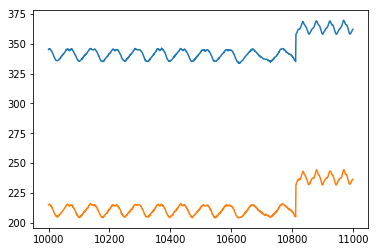

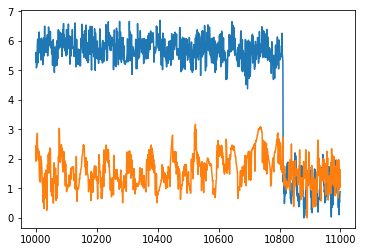

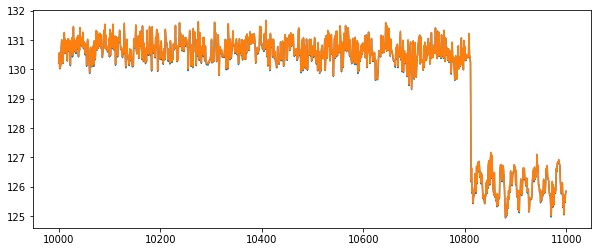

In [22]:
testFR = frame.iloc[10000:11000, :].copy()
testFR.loc[:,"Ydiff"] = pd.Series((testFR.pt1_cam1_Y - testFR.pt2_cam1_Y),  index = testFR.index)
testFR.loc[:,"Xdiff"] = pd.Series((testFR.pt1_cam1_X - testFR.pt2_cam1_X), index = testFR.index)
testFR.loc[:, "DistBwPts"] = np.sqrt((testFR.pt1_cam1_X - testFR.pt2_cam1_X)**2+ (testFR.pt1_cam1_Y - testFR.pt2_cam1_Y)**2 )



plt.plot(testFR.pt1_cam1_Y)
plt.plot(testFR.pt2_cam1_Y)
plt.show()
plt.plot(testFR.Ydiff - np.min(testFR.Ydiff))
plt.plot(testFR.Xdiff - np.min(testFR.Xdiff))
plt.show()
plt.figure(figsize = [10, 4])
plt.plot(testFR.Ydiff)
plt.plot(testFR.DistBwPts)